In [1]:
import pandas as pd
from pybit.unified_trading import HTTP, WebSocket

session = HTTP(
    testnet=False,
)

session.get_orderbook(category="linear", symbol="BTCUSDT")

{'retCode': 0,
 'retMsg': 'OK',
 'result': {'s': 'BTCUSDT',
  'b': [['96063.2', '2.513'],
   ['96063.1', '0.163'],
   ['96063', '0.002'],
   ['96062', '0.002'],
   ['96061.1', '0.002'],
   ['96060.6', '0.001'],
   ['96060.1', '0.002'],
   ['96060', '0.002'],
   ['96059.9', '0.001'],
   ['96059.1', '0.002'],
   ['96058.6', '0.208'],
   ['96058.5', '0.473'],
   ['96058.2', '0.002'],
   ['96057.2', '0.026'],
   ['96057.1', '0.024'],
   ['96056.8', '1.125'],
   ['96056.3', '0.002'],
   ['96056.1', '0.073'],
   ['96055.5', '0.082'],
   ['96055.3', '0.002'],
   ['96055.2', '0.001'],
   ['96055.1', '0.473'],
   ['96054.7', '0.004'],
   ['96054.6', '0.004'],
   ['96054.3', '0.002']],
  'a': [['96063.3', '1.26'],
   ['96064', '0.001'],
   ['96065.2', '0.001'],
   ['96066', '0.002'],
   ['96066.1', '0.001'],
   ['96066.5', '0.001'],
   ['96067.1', '0.014'],
   ['96067.3', '0.002'],
   ['96067.4', '0.001'],
   ['96068', '0.001'],
   ['96068.3', '0.005'],
   ['96068.9', '0.001'],
   ['96069.1', '0

In [19]:
from time import sleep

ws = WebSocket(
    testnet=False,
    channel_type="linear",
)

frames = []


def handle_message(message):
    ts = message["ts"]
    bids = message["data"]["b"]
    asks = message["data"]["a"]

    bids_df = pd.DataFrame(bids, columns=["price", "size"])
    asks_df = pd.DataFrame(asks, columns=["price", "size"])
    bids_df["ts"] = ts
    asks_df["ts"] = ts
    bids_df["side"] = "bid"
    asks_df["side"] = "ask"

    frames.append(bids_df)
    frames.append(asks_df)


ws.orderbook_stream(50, "BTCUSDT", handle_message)
sleep(20)
ws.exit()

df = pd.concat(frames, ignore_index=True)
df = df.sort_values(by=["side", "price"])

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# если ts в миллисекундных timestamp'ах:
df["ts"] = pd.to_datetime(df["ts"], unit="ms")  # или убери unit, если уже datetime

# на всякий случай
df["price"] = df["price"].astype(float)
df["size"] = df["size"].astype(float)

# подпишем размер знаком:
# bid = +size, ask = -size (чтоб видеть дисбаланс цветом)
df["signed_size"] = np.where(df["side"] == "bid", df["size"], -df["size"])

# строим матрицу: строки = цена, столбцы = время, значения = signed_size
heat = df.pivot_table(index="price", columns="ts", values="signed_size", aggfunc="sum")

# заодно отсортируем по цене (по возрастанию)
heat = heat.sort_index()

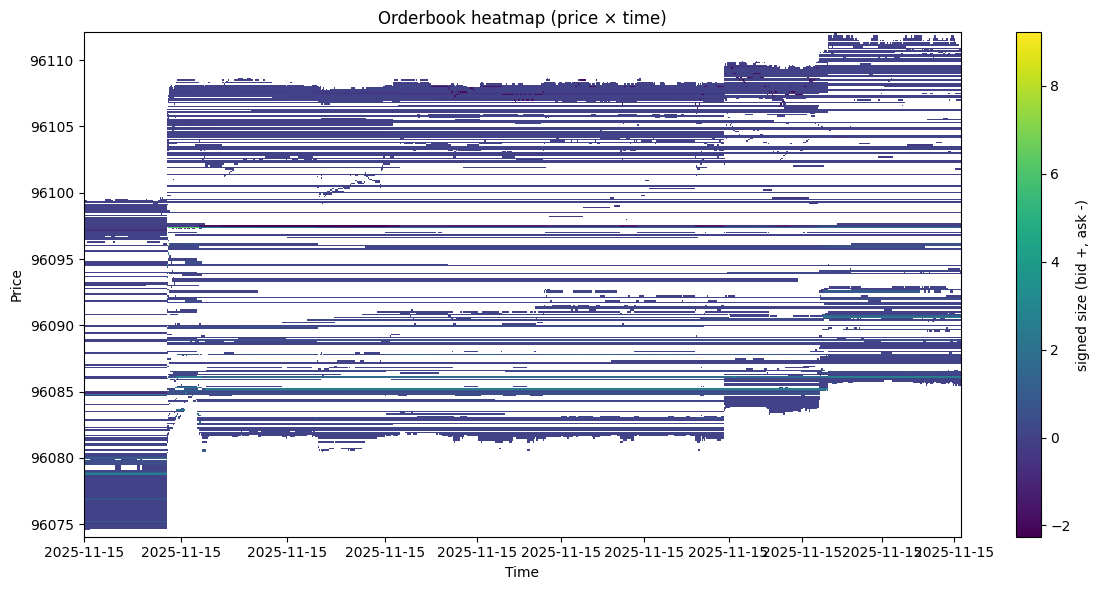

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

# pcolormesh: X = время, Y = цена, C = объём
c = ax.pcolormesh(
    heat.columns,  # время
    heat.index,  # цены
    heat.values,  # матрица объёмов
    shading="auto",
)

fig.colorbar(c, ax=ax, label="signed size (bid +, ask -)")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.set_title("Orderbook heatmap (price × time)")

# чтобы подписи по времени были не слишком частыми
if len(heat.columns) > 10:
    step = max(1, len(heat.columns) // 10)
    ax.set_xticks(heat.columns[::step])

plt.tight_layout()
plt.show()